In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report,confusion_matrix, zero_one_loss, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

import time
from datetime import timedelta, datetime
import gdown



In [22]:
#DOWNLOADING THE DATASET THROUGH DRIVE LINK TO COLAB CLOUD
file_id = "1CQ2Y9wcz_1EG47B4QwVcIrfwyjiUX7H9"
url = f"https://drive.google.com/uc?id={file_id}"
output = "cic_custom.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1CQ2Y9wcz_1EG47B4QwVcIrfwyjiUX7H9
From (redirected): https://drive.google.com/uc?id=1CQ2Y9wcz_1EG47B4QwVcIrfwyjiUX7H9&confirm=t&uuid=6c5d5222-e288-4e5c-8b4a-766d3c9c8e5f
To: /content/cic_custom.csv
100%|██████████| 487M/487M [00:07<00:00, 61.7MB/s]


'cic_custom.csv'

In [23]:
#READING DATASET
t0 = time.monotonic()
df = pd.read_csv(output)
t1 = time.monotonic()
print(f"Loading time: {t1-t0}")
print(df.head())

#LABELS SETTING
dfToReplace = df[['Label_Botnet','Label_Brute-force','Label_DDoS attack','Label_DoS attack','Label_Web attack']]

df['attack'] = dfToReplace.idxmax(axis=1).str.replace('Label_', '')
attacks = df['attack']
mapping = {'Botnet': 0, 'Brute-force':1,'DDoS attack':2, 'DoS attack':3,'Web attack':4}
df['attack'] = df['attack'].replace(mapping)

df = df.drop(['Label_Botnet','Label_Brute-force','Label_DDoS attack','Label_DoS attack','Label_Web attack'], axis=1)

print(df.head())

Loading time: 15.430236164999997
   Dst Port  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0  0.001221       0.285568      0.000003      0.000000         0.000000   
1  0.123293       0.000076      0.000006      0.000033         0.000002   
2  0.000320       0.000000      0.000000      0.000008         0.000000   
3  0.001221       0.086598      0.000003      0.000000         0.000000   
4  0.123293       0.000084      0.000006      0.000033         0.000002   

   Fwd Pkt Len Max  Fwd Pkt Len Min  Fwd Pkt Len Mean  Bwd Pkt Len Max  \
0         0.000000              0.0          0.000000         0.000000   
1         0.005058              0.0          0.006576         0.001719   
2         0.000000              0.0          0.000000         0.000000   
3         0.000000              0.0          0.000000         0.000000   
4         0.005058              0.0          0.006576         0.001719   

   Bwd Pkt Len Min  ...  Active Std  Idle Min  Protocol_0  Protocol_6  

<ipython-input-23-b5d6d2c20133>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['attack'] = df['attack'].replace(mapping)


In [25]:
#PREPROCESSING AND EDA
t = df['attack']
X = df.drop(['attack'],axis=1)

feature_names = X.columns.tolist()
class_names = ['Botnet', 'Brute-force','DDoS attack', 'DoS attack','Web attack']

from sklearn.model_selection import train_test_split
X_train,X_test,t_train,t_test = train_test_split(X,t,train_size=0.7,random_state=42)


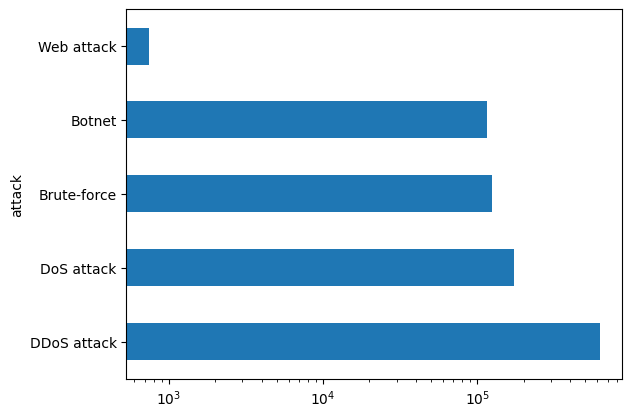

In [26]:
attacks = attacks.value_counts()
attacks.plot(kind='barh')
plt.xscale('log')

In [27]:
bool_cols = [col for col in X if
               df[col].dropna().value_counts().index.isin([0,1]).all()]
X[bool_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Fwd PSH Flags,1036364.0,0.002170,0.046534,0.0,0.0,0.0,0.0,1.0
Fwd URG Flags,1036364.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FIN Flag Cnt,1036364.0,0.001056,0.032473,0.0,0.0,0.0,0.0,1.0
SYN Flag Cnt,1036364.0,0.002170,0.046534,0.0,0.0,0.0,0.0,1.0
RST Flag Cnt,1036364.0,0.460499,0.498438,0.0,0.0,0.0,1.0,1.0
PSH Flag Cnt,1036364.0,0.615207,0.486547,0.0,0.0,1.0,1.0,1.0
ACK Flag Cnt,1036364.0,0.381454,0.485744,0.0,0.0,0.0,1.0,1.0
URG Flag Cnt,1036364.0,0.025881,0.158780,0.0,0.0,0.0,0.0,1.0
CWE Flag Count,1036364.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Protocol_0,1036364.0,0.000208,0.014435,0.0,0.0,0.0,0.0,1.0


In [28]:
numerical_cols = X.drop(bool_cols, axis=1)
numerical_cols.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Dst Port,1036364.0,1.690332e-02,0.058226,0.000000e+00,1.220722e-03,1.220722e-03,1.220722e-03,0.998856
Flow Duration,1036364.0,5.467554e-02,0.125952,0.000000e+00,1.010583e-04,3.268433e-03,2.123535e-02,1.000000
Tot Fwd Pkts,1036364.0,7.448292e-04,0.017441,0.000000e+00,3.229682e-06,6.459364e-06,6.459364e-06,1.000000
Tot Bwd Pkts,1036364.0,3.011948e-05,0.000045,0.000000e+00,0.000000e+00,3.303301e-05,3.303301e-05,0.001016
TotLen Fwd Pkts,1036364.0,5.219254e-05,0.001197,0.000000e+00,0.000000e+00,1.385120e-07,2.188489e-06,0.068620
Fwd Pkt Len Max,1036364.0,2.184018e-03,0.003082,0.000000e+00,0.000000e+00,3.103181e-04,4.903026e-03,0.022653
Fwd Pkt Len Min,1036364.0,1.002101e-04,0.003861,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.342466
Fwd Pkt Len Mean,1036364.0,2.250427e-03,0.002951,0.000000e+00,0.000000e+00,4.033878e-04,5.387780e-03,0.042105
Bwd Pkt Len Max,1036364.0,6.968487e-03,0.007144,0.000000e+00,0.000000e+00,1.719110e-03,1.479662e-02,0.061581
Bwd Pkt Len Min,1036364.0,6.523069e-07,0.000383,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.225342


In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
#importing models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

Correlation matrix building time 8.248031440999966


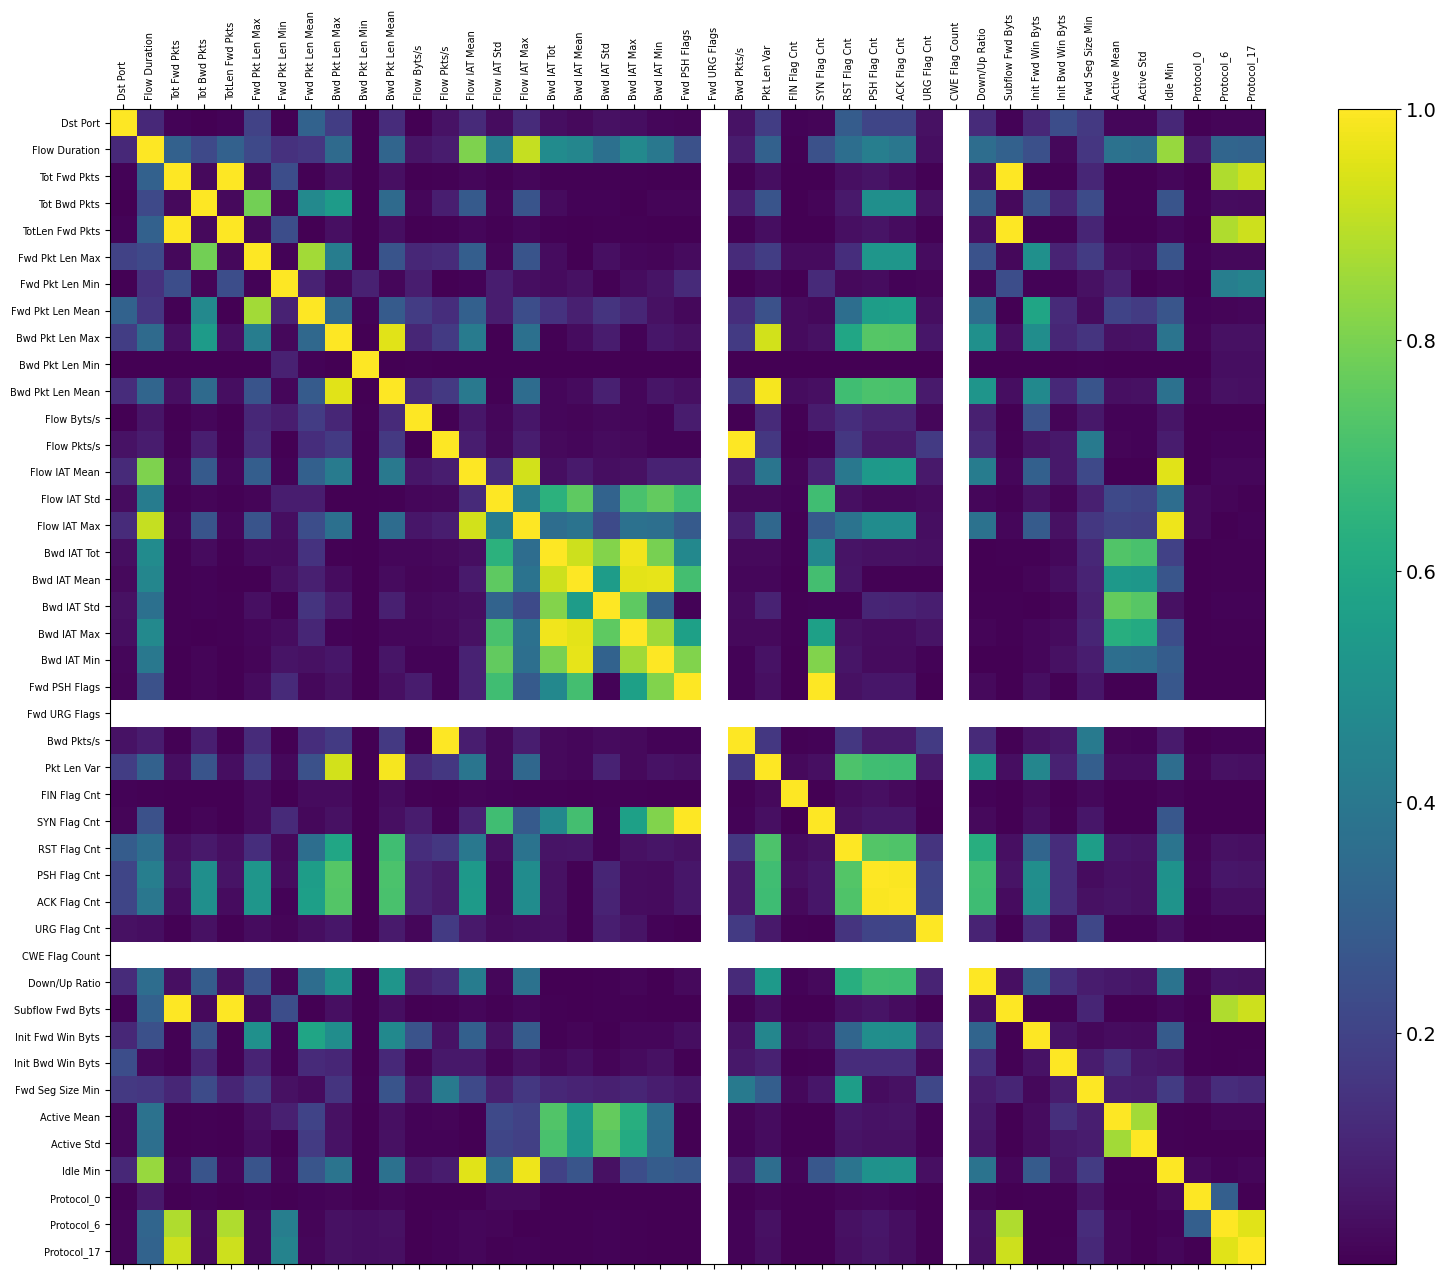

In [33]:
#CORRELATION MATRIX
t0 = time.monotonic()
fig, ax = plt.subplots(figsize=(19, 15))
cax = ax.matshow(abs(X.corr()))


ax.set_xticks(np.arange(X.shape[1]))
ax.set_xticklabels(list(X), fontsize=7, rotation=90)
ax.set_yticks(np.arange(X.shape[1]))
ax.set_yticklabels(list(X), fontsize=7)


cb = fig.colorbar(cax)
cb.ax.tick_params(labelsize=14)

t1 = time.monotonic()
print(f"Correlation matrix building time {t1-t0}")

plt.show()

In [ ]:
#PRUNING, SEARCHING FOR THE BEST CCP_ALPHA VALUE

t0 = time.monotonic()
ccp_values=[0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.05]
clfs = []
for ccp_alpha in ccp_values:
    clf = DecisionTreeClassifier(criterion='entropy',random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train,t_train)
    test_scores = clf.score(X_train,t_train)
    clfs.append(clf)
    print("Number of nodes in the tree with ccp_alpha {} is {} , depth {} or {}, and score {}".format(ccp_alpha, clf.tree_.node_count,  clf.tree_.max_depth, clf.get_depth(), test_scores )  )
t1 = time.monotonic()

print(f"Pruming time: {t1-t0}")

Number of nodes in the tree with ccp_alpha 0 is 127 , depth 15 or 15, and score 0.988575430006589
Number of nodes in the tree with ccp_alpha 0.001 is 21 , depth 6 or 6, and score 0.9861135233936266
Number of nodes in the tree with ccp_alpha 0.002 is 13 , depth 4 or 4, and score 0.9841065043407301
Number of nodes in the tree with ccp_alpha 0.005 is 13 , depth 4 or 4, and score 0.9841065043407301
Number of nodes in the tree with ccp_alpha 0.01 is 11 , depth 3 or 3, and score 0.9836543736749677
Number of nodes in the tree with ccp_alpha 0.02 is 9 , depth 3 or 3, and score 0.9829885837006895
Number of nodes in the tree with ccp_alpha 0.03 is 7 , depth 2 or 2, and score 0.9829885837006895
Number of nodes in the tree with ccp_alpha 0.05 is 7 , depth 2 or 2, and score 0.9829885837006895
Pruming time: 70.23593317599989


In [ ]:
#DECISION TREE
DT = DecisionTreeClassifier(criterion='entropy', random_state=42,max_depth=14, ccp_alpha=0, splitter = 'best')
#Best parameters obtained for Decision tree:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 12, 'splitter': 'best'}
#Obtained with GridsearchCV
t0 =  time.monotonic()
DT.fit(X_train,t_train)
t1 = time.monotonic()

print(f"Decision tree training time: {t1-t0}")

print(DT.score(X_train,t_train))
print(DT.score(X_test,t_test))




Decision tree training time: 7.884354080999856
0.988575430006589
0.9885143610691197


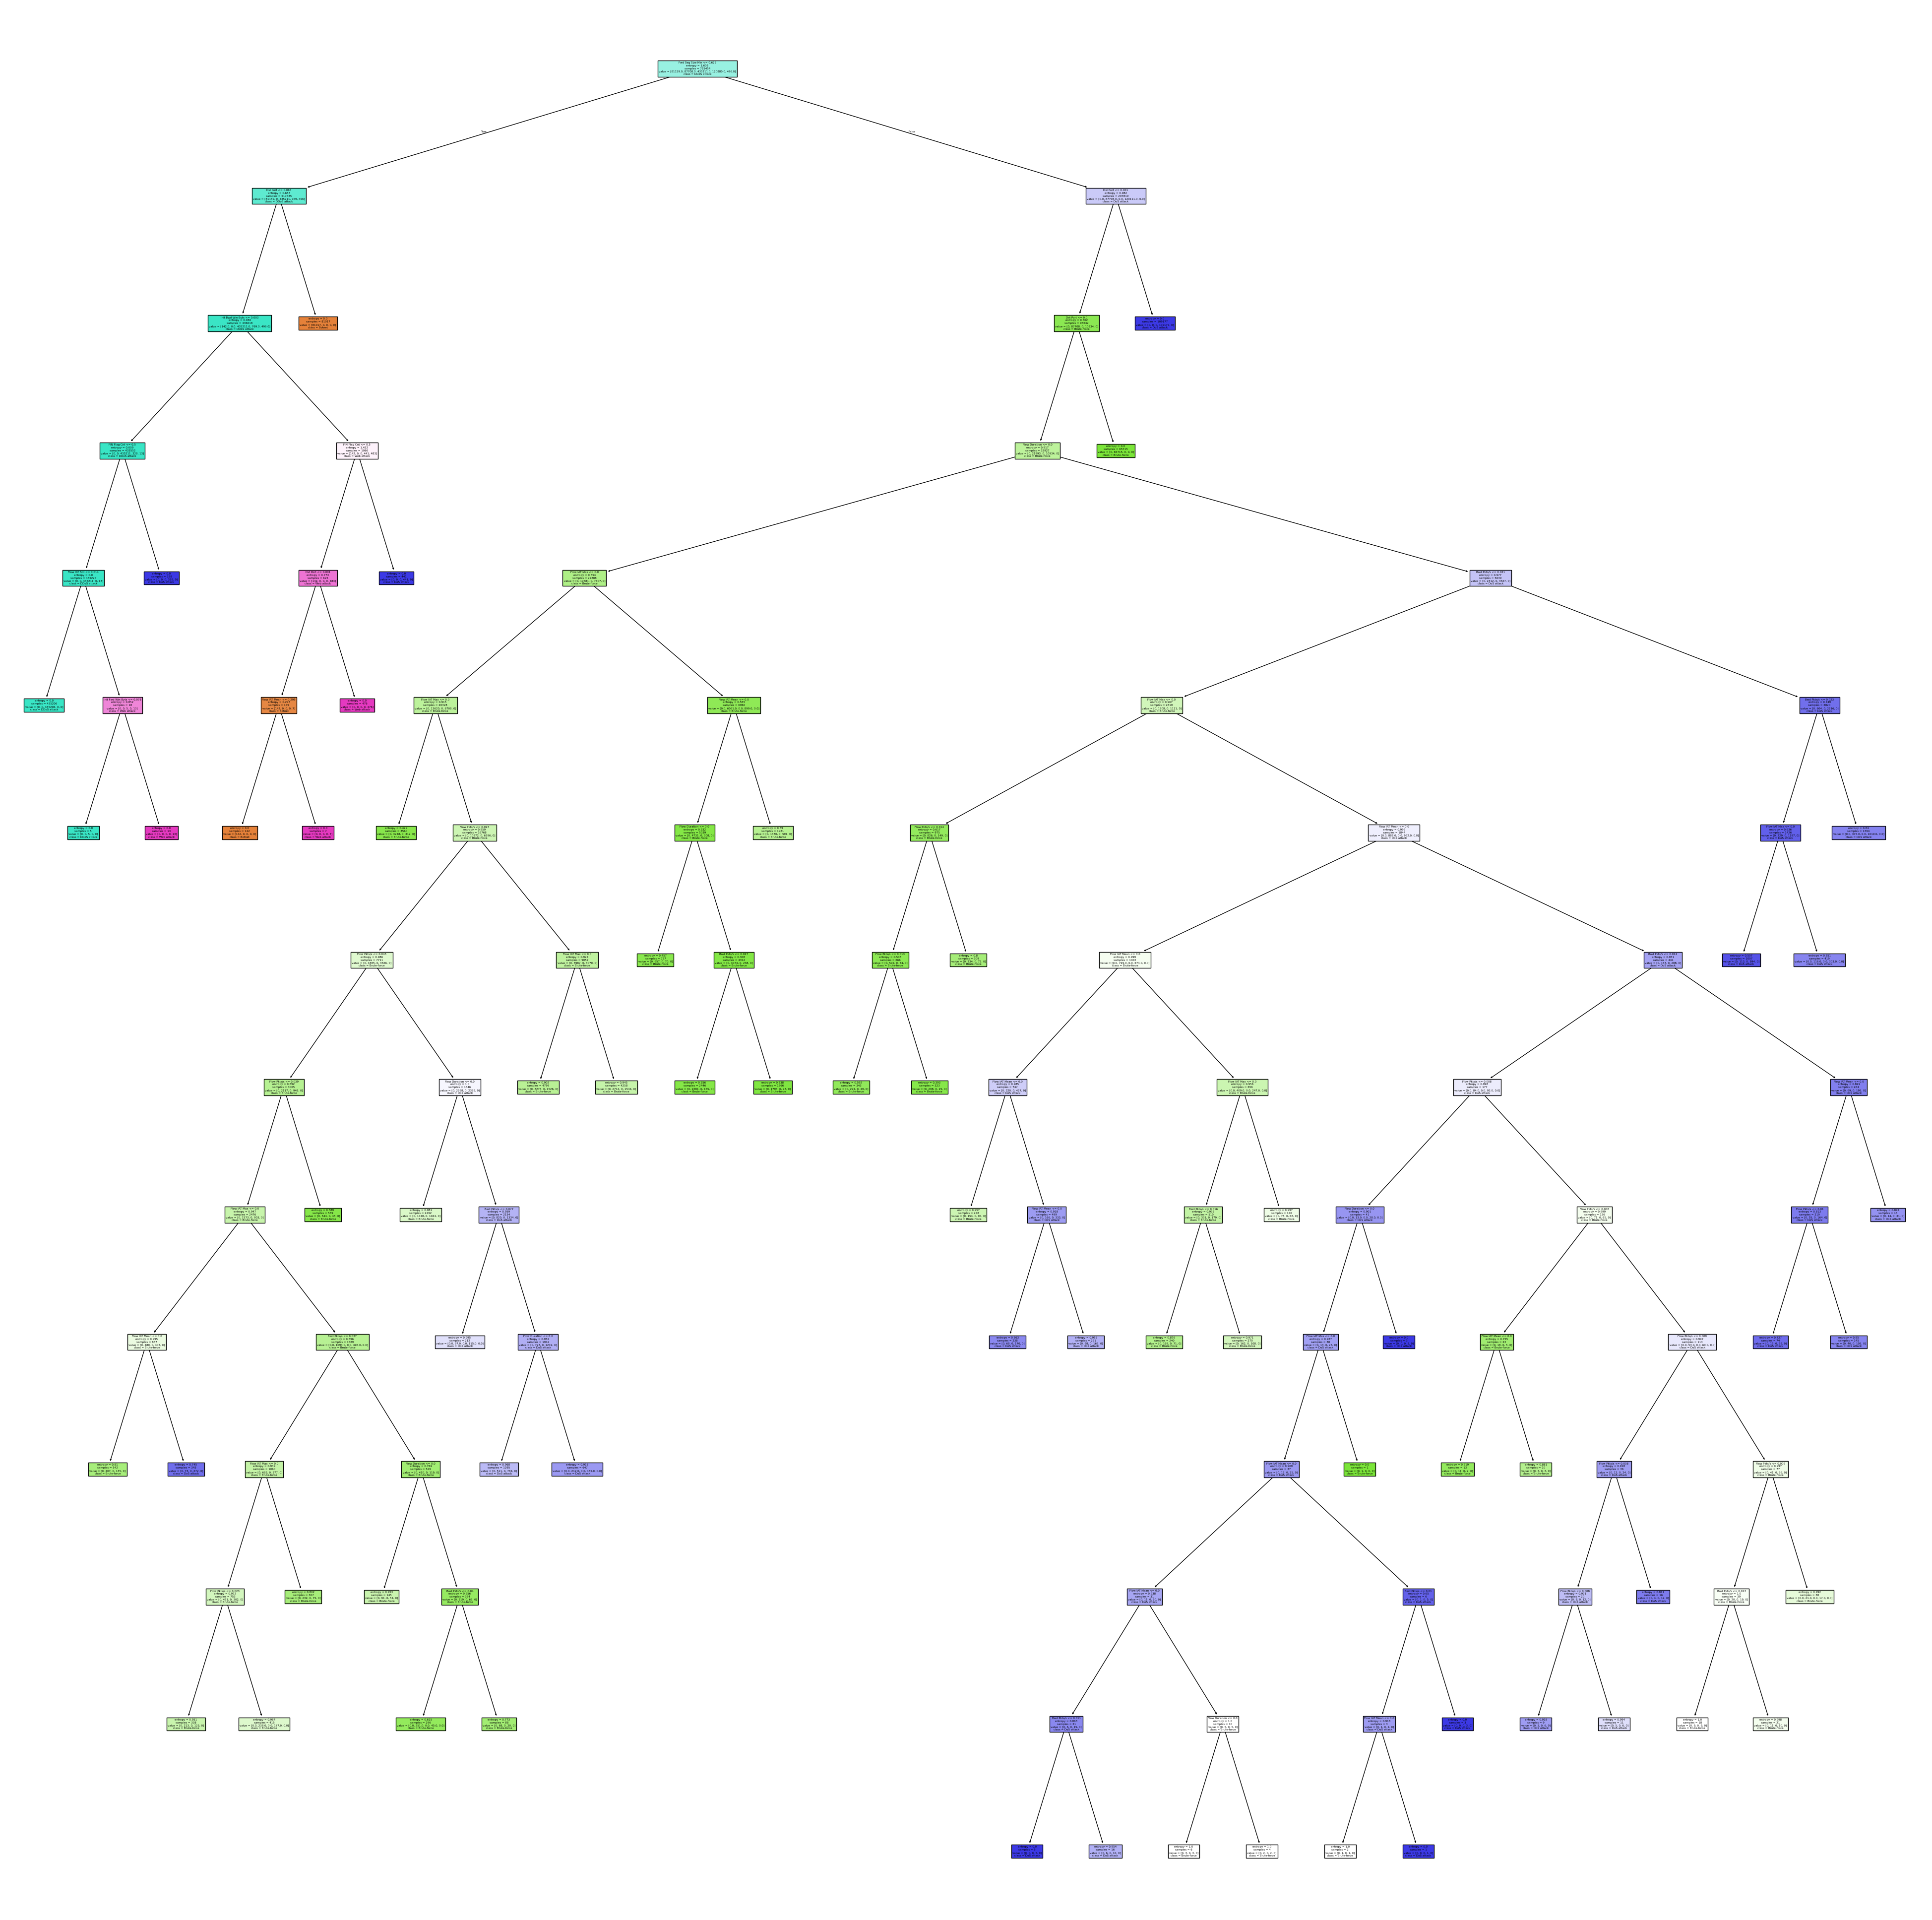

Decision tree plot and show time: 5.977122211000051


In [ ]:
#PLOTTING THE TREE
t0 = time.monotonic()
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(DT, feature_names=feature_names, class_names=class_names, filled=True)
plt.show()
t1 = time.monotonic()
print(f"Decision tree plot and show time: {t1-t0}")

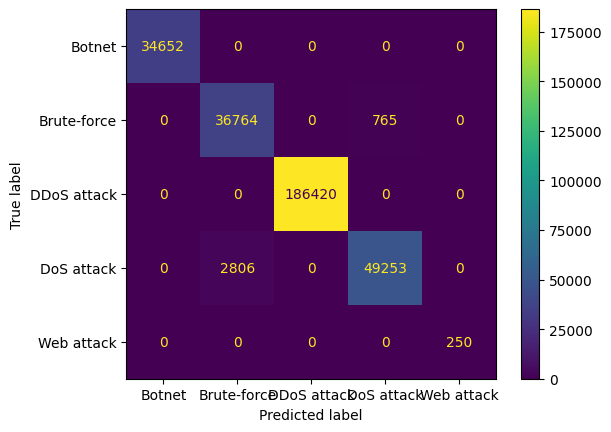

In [ ]:
#DECISION TREE PREDICTION SCORES
t_predicted_DT = DT.predict(X_test)
results_pruned = confusion_matrix(t_test,t_predicted_DT)
error_pruned = zero_one_loss(t_test,t_predicted_DT)
disp = ConfusionMatrixDisplay(confusion_matrix=results_pruned, display_labels=class_names)
disp.plot()
plt.show()

In [ ]:
#RANDOM FOREST
RF = RandomForestClassifier(max_depth = 14,n_estimators=100, criterion='gini', random_state=42)
#best parameters obtained by using GridSearchCV
t0 = time.monotonic()
RF.fit(X_train,t_train)
t1 = time.monotonic()
print(f"Random forest training time: {t1-t0}")

print(RF.score(X_train,t_train))
print(RF.score(X_test,t_test))

Random forest training time: 125.89182190500014
0.988575430006589
0.9885368756231707


[[ 34651      0      0      1      0]
 [     0  36763      0    766      0]
 [     0      0 186420      0      0]
 [     0   2797      0  49262      0]
 [     0      0      0      0    250]] 
Error:  0.011463124376829281


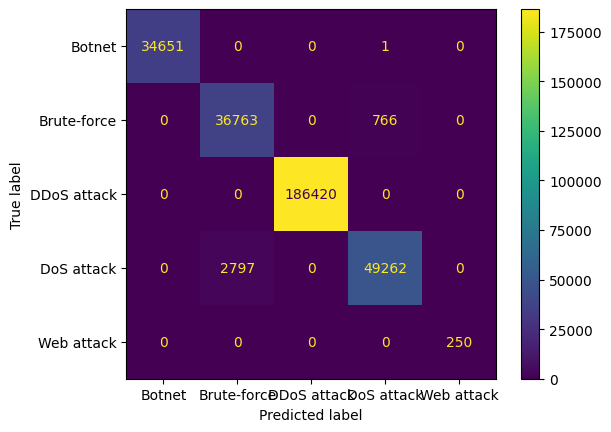

In [ ]:
#RANDOM FOREST PREDICTION SCORES
t_predicted_RF = RF.predict(X_test)
results_RF = confusion_matrix(t_test, t_predicted_RF)
error_RF = zero_one_loss(t_test, t_predicted_RF)
print(results_RF,'\nError: ',error_RF)
disp_RF = ConfusionMatrixDisplay(confusion_matrix=results_RF, display_labels=class_names)
disp_RF.plot()
plt.show()

In [ ]:
#XGB
XGB = xgb.XGBClassifier(objective="multi:softprob", random_state=42, learning_rate=0.1, max_depth = 10)

t0 = time.monotonic()
XGB.fit(X_train, t_train)
t1 = time.monotonic()
print(f"XGBoost training time: {t1-t0}")

print(XGB.score(X_train,t_train))
print(XGB.score(X_test,t_test))

XGBoost training time: 56.45222207300003
0.9881991139341709
0.9881090990962015


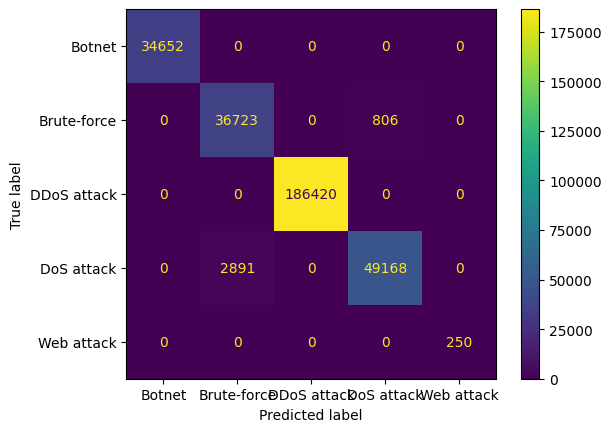

In [ ]:
#XGB PREDICTION SCORES
t_predicted_XGB = XGB.predict(X_test)
results_XGB = confusion_matrix(t_test, t_predicted_XGB)
error_XGB = zero_one_loss(t_test, t_predicted_XGB)
disp_XGB = ConfusionMatrixDisplay(confusion_matrix=results_XGB, display_labels=class_names)
disp_XGB.plot()
plt.show()